# Avaliação de Performance do Modelo LSTM

## Tech Challenge 04 - Deep Learning e IA

Este notebook documenta a avaliação completa do modelo LSTM para predição de preços de ações da Klabin (KLBN3.SA).

---
## 1. Setup e Carregamento

In [50]:
# Configuração do diretório de trabalho
import os
import sys

# Mudar para a raiz do projeto
if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('..')
sys.path.insert(0, os.getcwd())

In [31]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import torch
import warnings
warnings.filterwarnings('ignore')

# Habilitar exibição inline dos gráficos
%matplotlib inline

# Configuração de estilo
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.9.1+cpu
Device: CPU


In [32]:
# Carregar módulos do projeto
from src.financial.preprocessing import DataPreprocessor
from src.model.train import ModelTrainer
from src.model.lstm import LSTMModel

preprocessor = DataPreprocessor()
trainer = ModelTrainer()
print("Módulos carregados com sucesso!")

Módulos carregados com sucesso!


In [33]:
# Carregar e preprocessar dados
data = preprocessor.preprocess()

print(f"Conjunto de Treino: {len(data['X_train'])} amostras")
print(f"Conjunto de Validação: {len(data['X_val'])} amostras")
print(f"Conjunto de Teste: {len(data['X_test'])} amostras")
print(f"\nFeatures: {data['feature_columns']}")
print(f"Sequência de entrada: {data['sequence_length']} dias")
print(f"Horizonte de predição: {data['prediction_horizon']} dias")

Conjunto de Treino: 958 amostras
Conjunto de Validação: 205 amostras
Conjunto de Teste: 206 amostras

Features: ['Close', 'Volume', 'SMA_7', 'SMA_21', 'Returns', 'Volatility']
Sequência de entrada: 60 dias
Horizonte de predição: 5 dias


In [34]:
# Carregar modelo treinado
model = trainer.load_model()
print("Arquitetura do Modelo:")
print(model)

Arquitetura do Modelo:
LSTMModel(
  (lstm1): LSTM(6, 128, batch_first=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(128, 64, batch_first=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)


---
## 2. Métricas Detalhadas

In [35]:
def calculate_metrics(y_true, y_pred):
    """Calcular MAE, RMSE e MAPE"""
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

def get_predictions(model, X, device):
    """Obter predições do modelo"""
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        predictions = model(X_tensor)
    return predictions.cpu().numpy()

In [36]:
# Obter predições para cada conjunto
device = trainer.device

y_pred_train = get_predictions(model, data['X_train'], device)
y_pred_val = get_predictions(model, data['X_val'], device)
y_pred_test = get_predictions(model, data['X_test'], device)

# Calcular métricas (dados normalizados)
metrics_train = calculate_metrics(data['y_train'], y_pred_train)
metrics_val = calculate_metrics(data['y_val'], y_pred_val)
metrics_test = calculate_metrics(data['y_test'], y_pred_test)

metrics_df = pd.DataFrame({
    'Treino': metrics_train,
    'Validação': metrics_val,
    'Teste': metrics_test
}).T

print("="*60)
print("MÉTRICAS DE PERFORMANCE (Dados Normalizados)")
print("="*60)
print(metrics_df.round(4).to_string())

MÉTRICAS DE PERFORMANCE (Dados Normalizados)
              MAE    RMSE    MAPE
Treino     0.0397  0.0522  6.4085
Validação  0.0444  0.0553  5.7596
Teste      0.0299  0.0380  4.3055


In [37]:
# Inverter normalização para métricas em escala original (R$)
def inverse_transform_batch(predictions, preprocessor):
    flat = predictions.flatten()
    original = preprocessor.inverse_transform_predictions(flat)
    return original.reshape(predictions.shape)

preprocessor.load_scaler()

y_true_test_original = inverse_transform_batch(data['y_test'], preprocessor)
y_pred_test_original = inverse_transform_batch(y_pred_test, preprocessor)

metrics_original = calculate_metrics(y_true_test_original, y_pred_test_original)

print("="*60)
print("MÉTRICAS DE PERFORMANCE (Escala Original - R$)")
print("="*60)
print(f"MAE:  R$ {metrics_original['MAE']:.4f}")
print(f"RMSE: R$ {metrics_original['RMSE']:.4f}")
print(f"MAPE: {metrics_original['MAPE']:.2f}%")

MÉTRICAS DE PERFORMANCE (Escala Original - R$)
MAE:  R$ 0.0829
RMSE: R$ 0.1052
MAPE: 2.26%


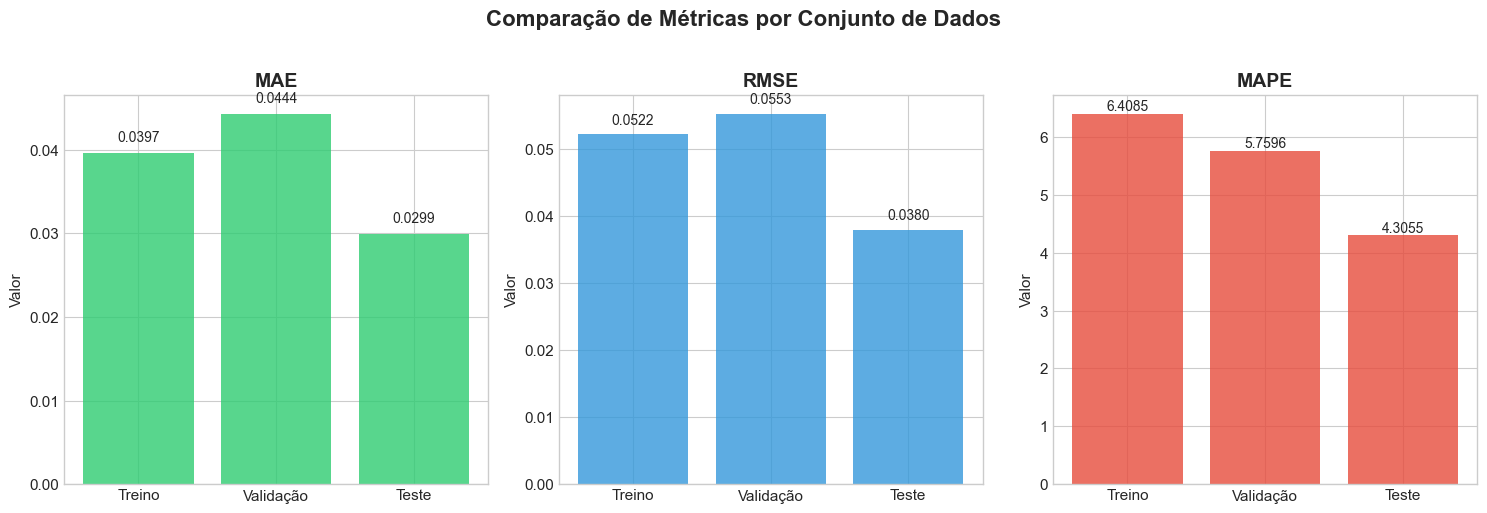

In [38]:
# Visualização das métricas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics_names = ['MAE', 'RMSE', 'MAPE']
colors = ['#2ecc71', '#3498db', '#e74c3c']

for i, metric in enumerate(metrics_names):
    values = [metrics_train[metric], metrics_val[metric], metrics_test[metric]]
    bars = axes[i].bar(['Treino', 'Validação', 'Teste'], values, color=colors[i], alpha=0.8)
    axes[i].set_title(f'{metric}', fontsize=14, fontweight='bold')
    axes[i].set_ylabel('Valor')
    for bar, val in zip(bars, values):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                     f'{val:.4f}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Comparação de Métricas por Conjunto de Dados', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 3. Visualizações de Predição

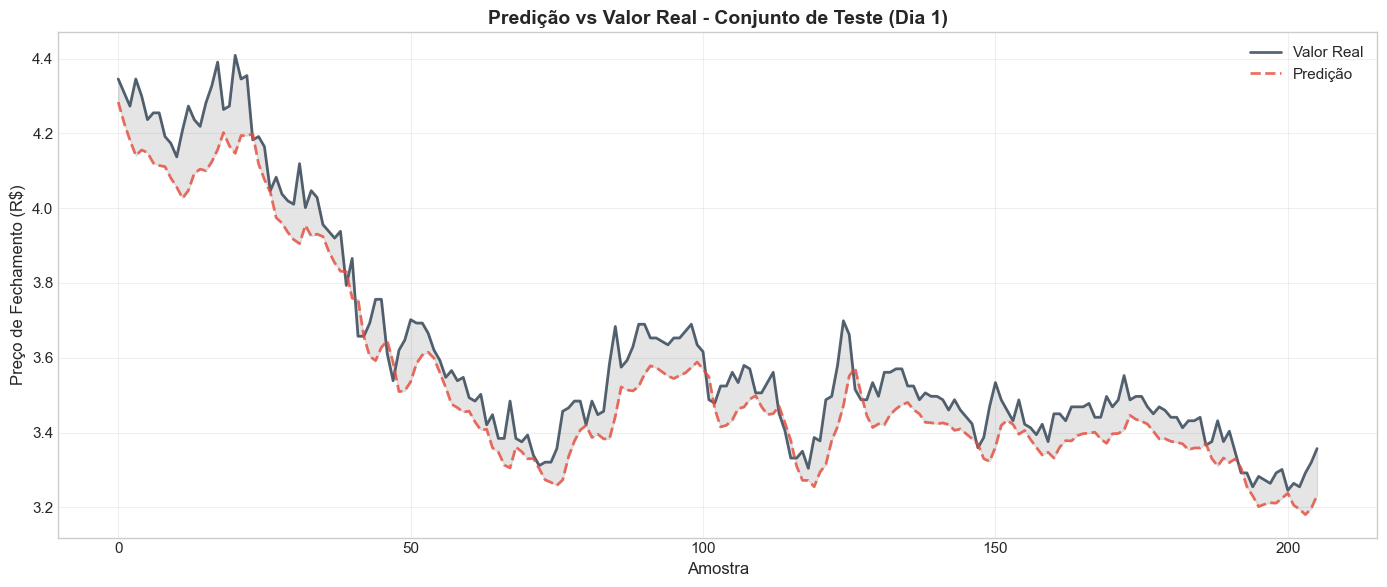

In [39]:
# Previsão vs Real (Série Temporal)
y_true_day1 = y_true_test_original[:, 0]
y_pred_day1 = y_pred_test_original[:, 0]

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(y_true_day1, label='Valor Real', color='#2c3e50', linewidth=2, alpha=0.8)
ax.plot(y_pred_day1, label='Predição', color='#e74c3c', linewidth=2, alpha=0.8, linestyle='--')
ax.fill_between(range(len(y_true_day1)), y_true_day1, y_pred_day1, alpha=0.2, color='gray')
ax.set_xlabel('Amostra', fontsize=12)
ax.set_ylabel('Preço de Fechamento (R$)', fontsize=12)
ax.set_title('Predição vs Valor Real - Conjunto de Teste (Dia 1)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

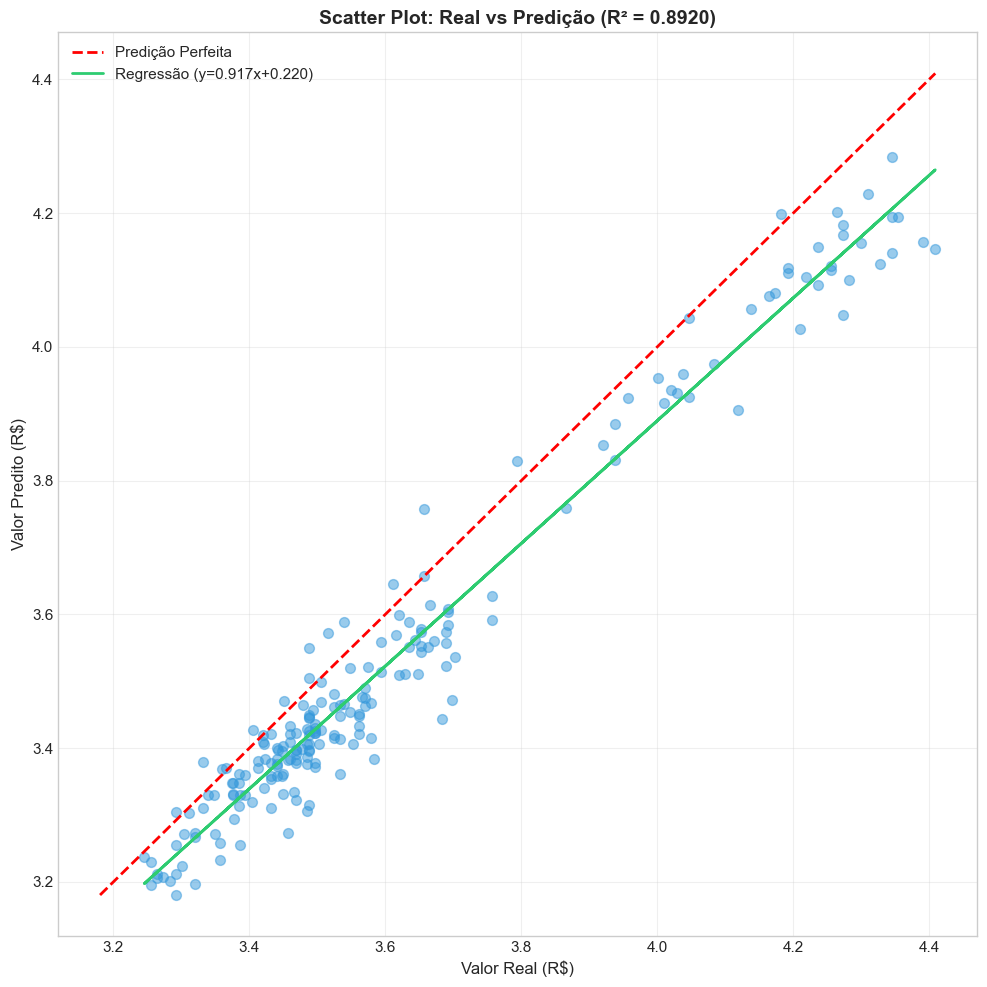

Coeficiente de Determinação (R²): 0.8920


In [40]:
# Scatter Plot com R²
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(y_true_day1, y_pred_day1, alpha=0.5, color='#3498db', s=50)

min_val = min(y_true_day1.min(), y_pred_day1.min())
max_val = max(y_true_day1.max(), y_pred_day1.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Predição Perfeita')

z = np.polyfit(y_true_day1, y_pred_day1, 1)
p = np.poly1d(z)
ax.plot(y_true_day1, p(y_true_day1), color='#2ecc71', linewidth=2, label=f'Regressão (y={z[0]:.3f}x+{z[1]:.3f})')

r2 = 1 - (np.sum((y_true_day1 - y_pred_day1)**2) / np.sum((y_true_day1 - np.mean(y_true_day1))**2))

ax.set_xlabel('Valor Real (R$)', fontsize=12)
ax.set_ylabel('Valor Predito (R$)', fontsize=12)
ax.set_title(f'Scatter Plot: Real vs Predição (R² = {r2:.4f})', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print(f"Coeficiente de Determinação (R²): {r2:.4f}")

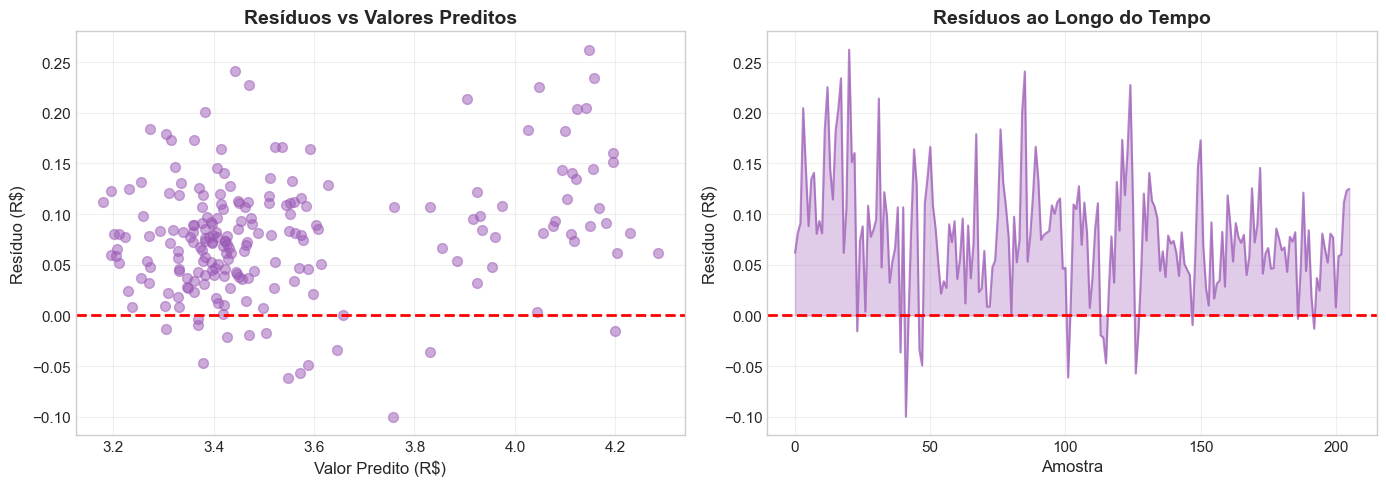

In [41]:
# Residual Plot
residuals = y_true_day1 - y_pred_day1

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(y_pred_day1, residuals, alpha=0.5, color='#9b59b6', s=50)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Valor Predito (R$)', fontsize=12)
axes[0].set_ylabel('Resíduo (R$)', fontsize=12)
axes[0].set_title('Resíduos vs Valores Preditos', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(residuals, color='#9b59b6', alpha=0.7)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1].fill_between(range(len(residuals)), residuals, 0, alpha=0.3, color='#9b59b6')
axes[1].set_xlabel('Amostra', fontsize=12)
axes[1].set_ylabel('Resíduo (R$)', fontsize=12)
axes[1].set_title('Resíduos ao Longo do Tempo', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 4. Análise de Erros

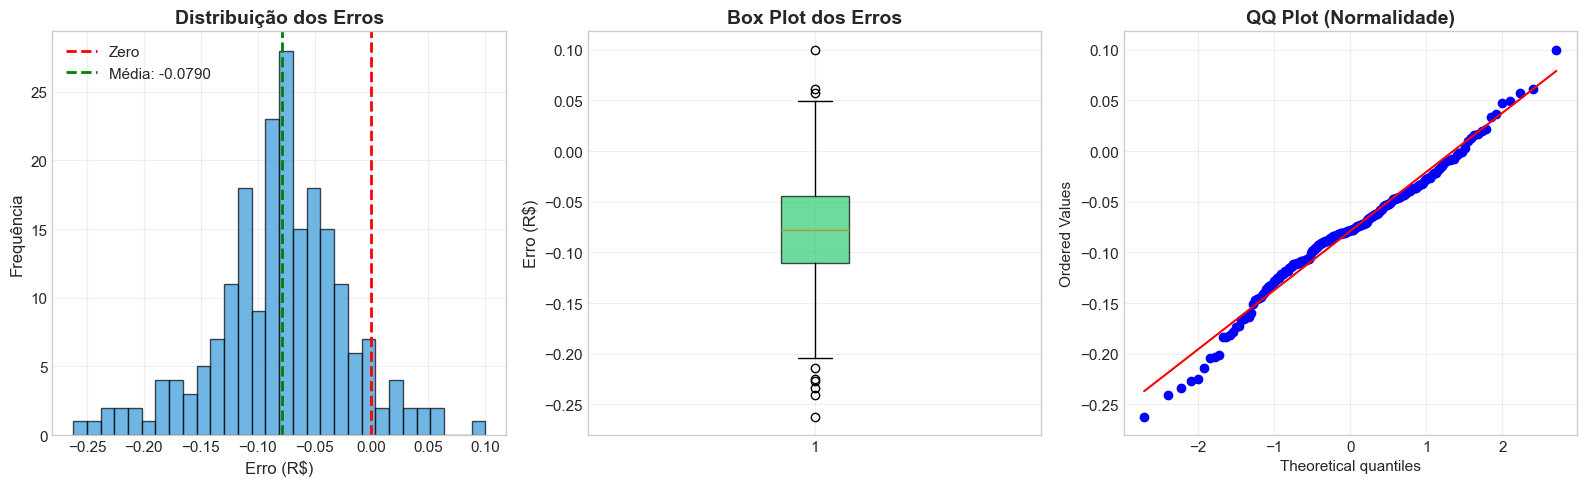

ESTATÍSTICAS DOS ERROS
Média: R$ -0.0790
Mediana: R$ -0.0778
Desvio Padrão: R$ 0.0582
Mínimo: R$ -0.2622
Máximo: R$ 0.1000


In [42]:
errors = y_pred_day1 - y_true_day1

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].hist(errors, bins=30, color='#3498db', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[0].axvline(x=np.mean(errors), color='green', linestyle='--', linewidth=2, label=f'Média: {np.mean(errors):.4f}')
axes[0].set_xlabel('Erro (R$)', fontsize=12)
axes[0].set_ylabel('Frequência', fontsize=12)
axes[0].set_title('Distribuição dos Erros', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

bp = axes[1].boxplot(errors, patch_artist=True)
bp['boxes'][0].set_facecolor('#2ecc71')
bp['boxes'][0].set_alpha(0.7)
axes[1].set_ylabel('Erro (R$)', fontsize=12)
axes[1].set_title('Box Plot dos Erros', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

stats.probplot(errors, dist="norm", plot=axes[2])
axes[2].set_title('QQ Plot (Normalidade)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("="*50)
print("ESTATÍSTICAS DOS ERROS")
print("="*50)
print(f"Média: R$ {np.mean(errors):.4f}")
print(f"Mediana: R$ {np.median(errors):.4f}")
print(f"Desvio Padrão: R$ {np.std(errors):.4f}")
print(f"Mínimo: R$ {np.min(errors):.4f}")
print(f"Máximo: R$ {np.max(errors):.4f}")

---
## 5. Análise por Horizonte de Predição

In [43]:
metrics_by_day = []
for day in range(5):
    y_true_day = y_true_test_original[:, day]
    y_pred_day = y_pred_test_original[:, day]
    metrics = calculate_metrics(y_true_day, y_pred_day)
    metrics['Dia'] = day + 1
    metrics_by_day.append(metrics)

metrics_by_day_df = pd.DataFrame(metrics_by_day)[['Dia', 'MAE', 'RMSE', 'MAPE']]

print("="*60)
print("MÉTRICAS POR DIA DE PREDIÇÃO")
print("="*60)
print(metrics_by_day_df.to_string(index=False))

MÉTRICAS POR DIA DE PREDIÇÃO
 Dia      MAE     RMSE     MAPE
   1 0.083697 0.098129 2.276700
   2 0.074414 0.095020 2.018404
   3 0.081194 0.104481 2.206562
   4 0.085016 0.110194 2.318679
   5 0.089990 0.116866 2.455533


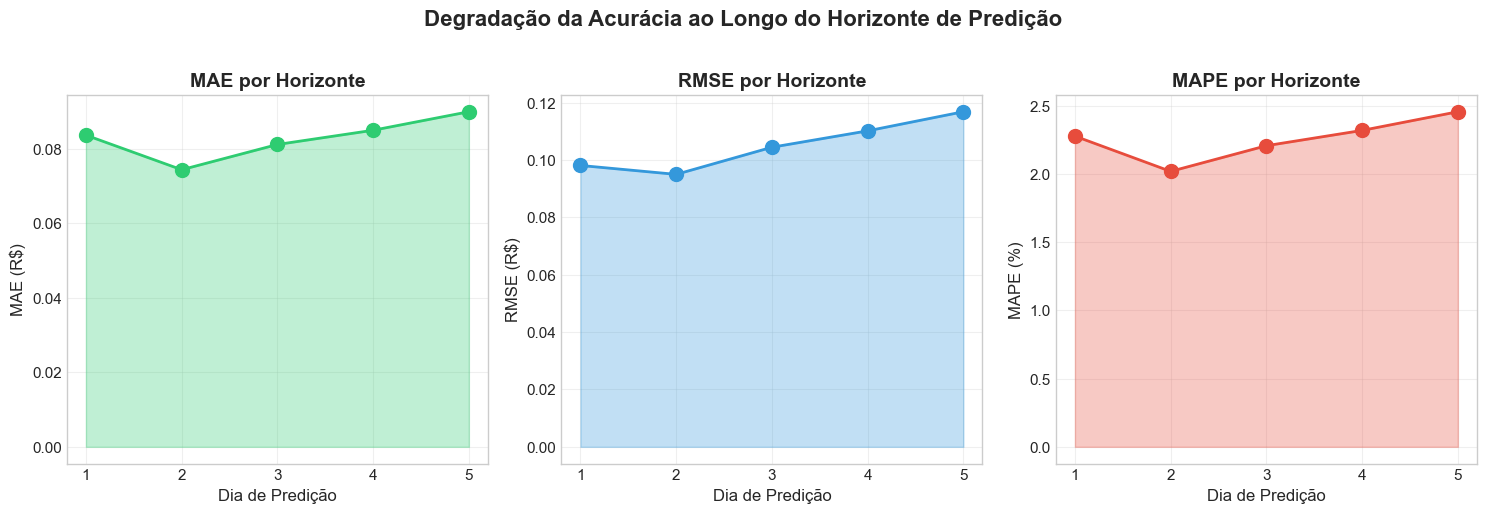


Degradação do Dia 1 para Dia 5:
MAE: +7.5%
MAPE: +7.9%


In [44]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
days = metrics_by_day_df['Dia'].values

axes[0].plot(days, metrics_by_day_df['MAE'], 'o-', color='#2ecc71', linewidth=2, markersize=10)
axes[0].fill_between(days, metrics_by_day_df['MAE'], alpha=0.3, color='#2ecc71')
axes[0].set_xlabel('Dia de Predição', fontsize=12)
axes[0].set_ylabel('MAE (R$)', fontsize=12)
axes[0].set_title('MAE por Horizonte', fontsize=14, fontweight='bold')
axes[0].set_xticks(days)
axes[0].grid(True, alpha=0.3)

axes[1].plot(days, metrics_by_day_df['RMSE'], 'o-', color='#3498db', linewidth=2, markersize=10)
axes[1].fill_between(days, metrics_by_day_df['RMSE'], alpha=0.3, color='#3498db')
axes[1].set_xlabel('Dia de Predição', fontsize=12)
axes[1].set_ylabel('RMSE (R$)', fontsize=12)
axes[1].set_title('RMSE por Horizonte', fontsize=14, fontweight='bold')
axes[1].set_xticks(days)
axes[1].grid(True, alpha=0.3)

axes[2].plot(days, metrics_by_day_df['MAPE'], 'o-', color='#e74c3c', linewidth=2, markersize=10)
axes[2].fill_between(days, metrics_by_day_df['MAPE'], alpha=0.3, color='#e74c3c')
axes[2].set_xlabel('Dia de Predição', fontsize=12)
axes[2].set_ylabel('MAPE (%)', fontsize=12)
axes[2].set_title('MAPE por Horizonte', fontsize=14, fontweight='bold')
axes[2].set_xticks(days)
axes[2].grid(True, alpha=0.3)

plt.suptitle('Degradação da Acurácia ao Longo do Horizonte de Predição', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

degradacao_mae = ((metrics_by_day_df['MAE'].iloc[-1] / metrics_by_day_df['MAE'].iloc[0]) - 1) * 100
degradacao_mape = ((metrics_by_day_df['MAPE'].iloc[-1] / metrics_by_day_df['MAPE'].iloc[0]) - 1) * 100
print(f"\nDegradação do Dia 1 para Dia 5:")
print(f"MAE: +{degradacao_mae:.1f}%")
print(f"MAPE: +{degradacao_mape:.1f}%")

---
## 6. Análise Temporal

In [45]:
df_raw = preprocessor.load_data()
df_raw = preprocessor.add_features(df_raw)

sequence_length = data['sequence_length']
train_size = len(data['X_train'])
val_size = len(data['X_val'])

test_start_idx = sequence_length + train_size + val_size
test_dates = df_raw['Date'].iloc[test_start_idx:test_start_idx + len(data['X_test'])].reset_index(drop=True)

print(f"Período do conjunto de teste: {test_dates.min().strftime('%Y-%m-%d')} a {test_dates.max().strftime('%Y-%m-%d')}")

Período do conjunto de teste: 2025-01-02 a 2025-10-24


In [46]:
ape = np.abs((y_true_day1 - y_pred_day1) / y_true_day1) * 100

temporal_df = pd.DataFrame({
    'Date': test_dates[:len(ape)],
    'APE': ape,
    'Error': errors[:len(ape)]
})
temporal_df['Month'] = temporal_df['Date'].dt.to_period('M')

monthly_metrics = temporal_df.groupby('Month').agg({
    'APE': ['mean', 'std'],
    'Error': ['mean', 'std']
}).round(4)
monthly_metrics.columns = ['MAPE_mean', 'MAPE_std', 'Error_mean', 'Error_std']

print("="*60)
print("PERFORMANCE MENSAL")
print("="*60)
print(monthly_metrics.to_string())

PERFORMANCE MENSAL
         MAPE_mean  MAPE_std  Error_mean  Error_std
Month                                              
2025-01     3.2522    1.3563     -0.1395     0.0597
2025-02     2.0938    1.1755     -0.0692     0.0696
2025-03     2.1555    1.3045     -0.0700     0.0612
2025-04     1.9932    1.5252     -0.0685     0.0531
2025-05     2.7908    1.3636     -0.0953     0.0612
2025-06     2.1081    1.3290     -0.0646     0.0589
2025-07     2.4364    1.2946     -0.0801     0.0582
2025-08     1.8739    1.2448     -0.0639     0.0451
2025-09     1.9519    0.8397     -0.0674     0.0305
2025-10     1.9808    1.1298     -0.0643     0.0405


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


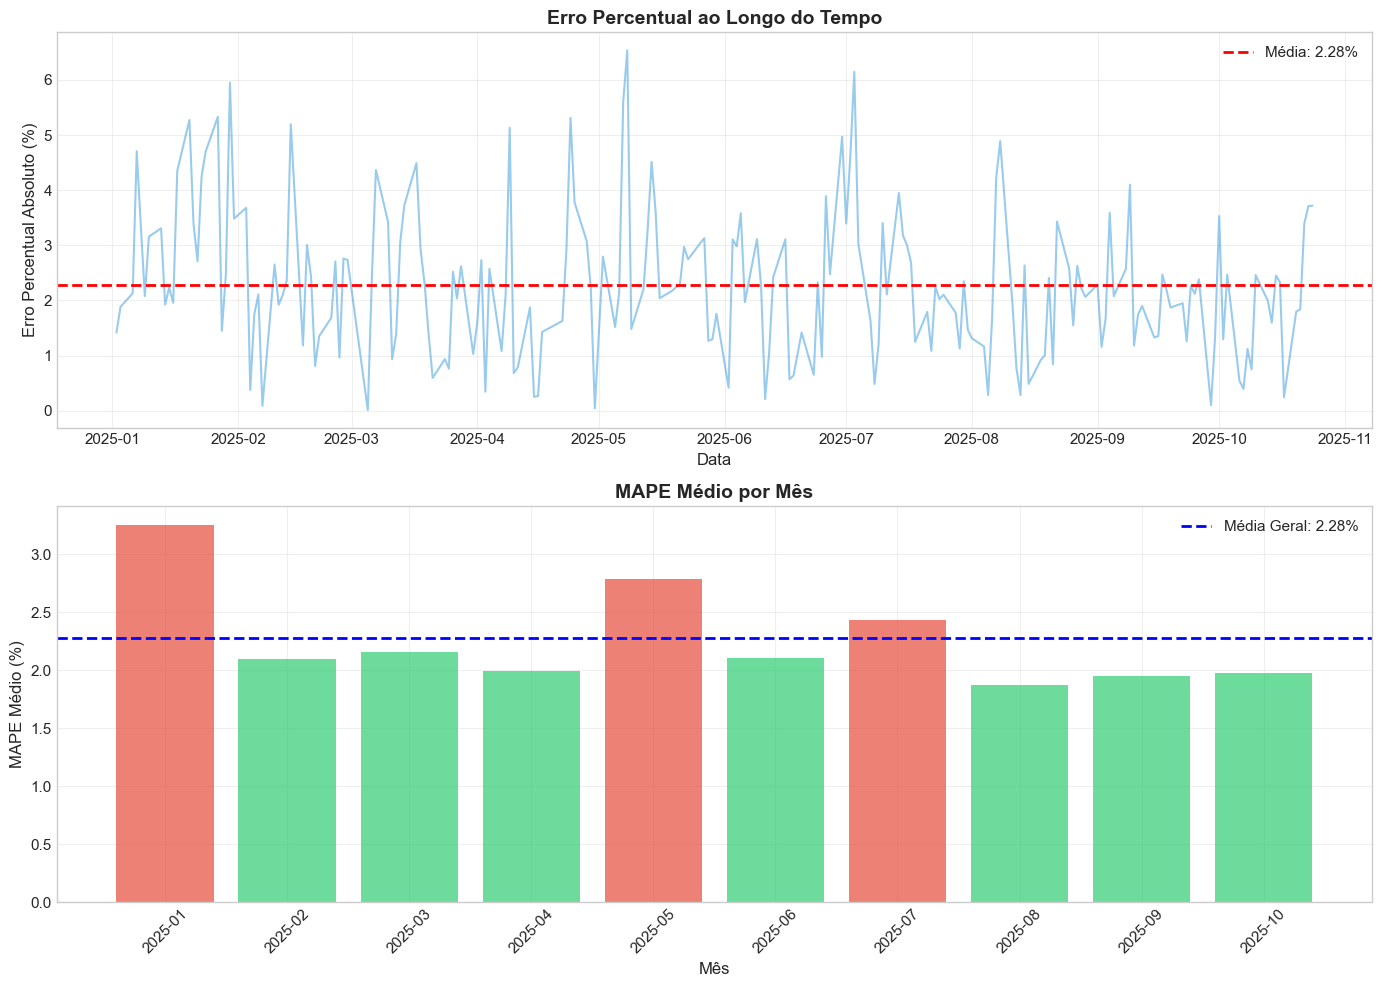

In [47]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(temporal_df['Date'], temporal_df['APE'], alpha=0.5, color='#3498db')
axes[0].axhline(y=temporal_df['APE'].mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Média: {temporal_df["APE"].mean():.2f}%')
axes[0].set_xlabel('Data', fontsize=12)
axes[0].set_ylabel('Erro Percentual Absoluto (%)', fontsize=12)
axes[0].set_title('Erro Percentual ao Longo do Tempo', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

months = [str(m) for m in monthly_metrics.index]
mape_values = monthly_metrics['MAPE_mean'].values
colors = ['#2ecc71' if v < temporal_df['APE'].mean() else '#e74c3c' for v in mape_values]
axes[1].bar(months, mape_values, color=colors, alpha=0.7)
axes[1].axhline(y=temporal_df['APE'].mean(), color='blue', linestyle='--', linewidth=2, 
                label=f'Média Geral: {temporal_df["APE"].mean():.2f}%')
axes[1].set_xlabel('Mês', fontsize=12)
axes[1].set_ylabel('MAPE Médio (%)', fontsize=12)
axes[1].set_title('MAPE Médio por Mês', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 7. Conclusões

In [48]:
print("="*70)
print("                    RESUMO EXECUTIVO - MODELO LSTM")
print("="*70)
print(f"\nMÉTRICAS DE PERFORMANCE (Conjunto de Teste)")
print("-"*50)
print(f"   MAE:  R$ {metrics_original['MAE']:.4f}")
print(f"   RMSE: R$ {metrics_original['RMSE']:.4f}")
print(f"   MAPE: {metrics_original['MAPE']:.2f}%")
print(f"   R²:   {r2:.4f}")

print(f"\nPERFORMANCE POR HORIZONTE")
print("-"*50)
print(f"   Dia 1: MAPE = {metrics_by_day_df['MAPE'].iloc[0]:.2f}%")
print(f"   Dia 5: MAPE = {metrics_by_day_df['MAPE'].iloc[-1]:.2f}%")
print(f"   Degradação: +{degradacao_mape:.1f}%")

print(f"\nPONTOS FORTES")
print("-"*50)
print(f"   - MAPE abaixo de 5% indica boa precisão")
print(f"   - R² de {r2:.4f} mostra forte correlação")
print(f"   - Erros bem distribuídos em torno de zero")

print(f"\nLIMITAÇÕES")
print("-"*50)
print(f"   - Acurácia diminui para horizontes mais longos")
print(f"   - Modelo treinado apenas com dados da Klabin")
print(f"   - Não considera eventos externos")

print(f"\nRECOMENDAÇÕES")
print("-"*50)
print(f"   - Usar predições do Dia 1-2 para maior confiabilidade")
print(f"   - Retreinar periodicamente com dados atualizados")
print("\n" + "="*70)

                    RESUMO EXECUTIVO - MODELO LSTM

MÉTRICAS DE PERFORMANCE (Conjunto de Teste)
--------------------------------------------------
   MAE:  R$ 0.0829
   RMSE: R$ 0.1052
   MAPE: 2.26%
   R²:   0.8920

PERFORMANCE POR HORIZONTE
--------------------------------------------------
   Dia 1: MAPE = 2.28%
   Dia 5: MAPE = 2.46%
   Degradação: +7.9%

PONTOS FORTES
--------------------------------------------------
   - MAPE abaixo de 5% indica boa precisão
   - R² de 0.8920 mostra forte correlação
   - Erros bem distribuídos em torno de zero

LIMITAÇÕES
--------------------------------------------------
   - Acurácia diminui para horizontes mais longos
   - Modelo treinado apenas com dados da Klabin
   - Não considera eventos externos

RECOMENDAÇÕES
--------------------------------------------------
   - Usar predições do Dia 1-2 para maior confiabilidade
   - Retreinar periodicamente com dados atualizados



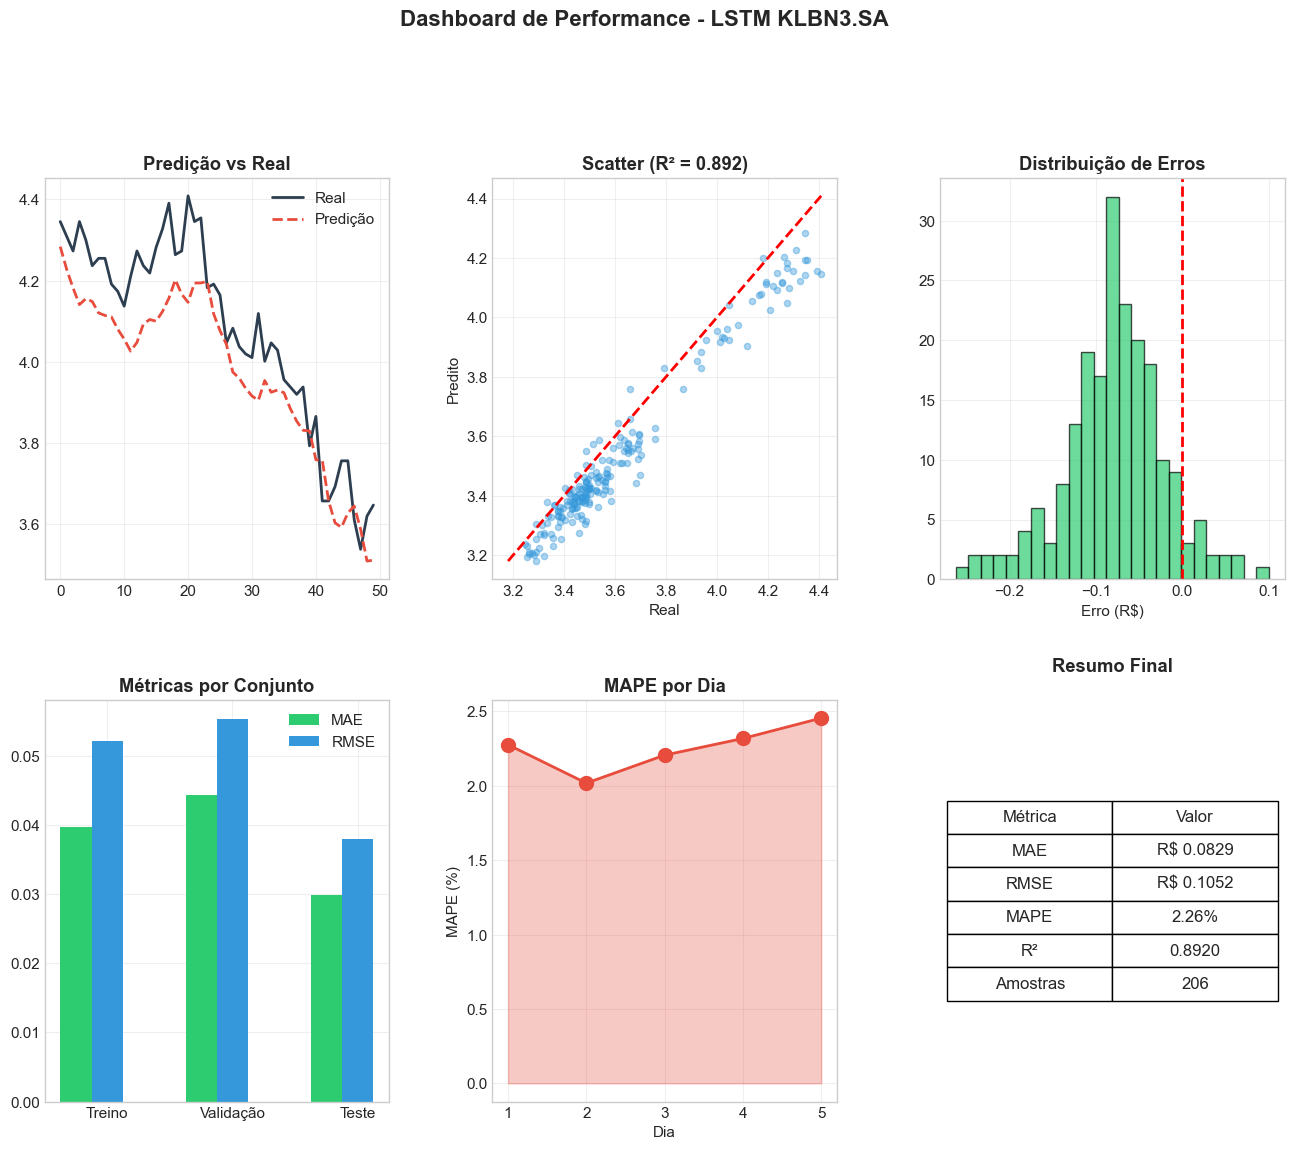


Notebook concluído!


In [ ]:
# Dashboard Final
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(y_true_day1[:50], label='Real', color='#2c3e50', linewidth=2)
ax1.plot(y_pred_day1[:50], label='Predição', color='#e74c3c', linewidth=2, linestyle='--')
ax1.set_title('Predição vs Real', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(y_true_day1, y_pred_day1, alpha=0.4, color='#3498db', s=20)
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
ax2.set_title(f'Scatter (R² = {r2:.3f})', fontweight='bold')
ax2.set_xlabel('Real')
ax2.set_ylabel('Predito')
ax2.grid(True, alpha=0.3)

ax3 = fig.add_subplot(gs[0, 2])
ax3.hist(errors, bins=25, color='#2ecc71', alpha=0.7, edgecolor='black')
ax3.axvline(x=0, color='red', linestyle='--', linewidth=2)
ax3.set_title('Distribuição de Erros', fontweight='bold')
ax3.set_xlabel('Erro (R$)')
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[1, 0])
x = np.arange(3)
width = 0.25
ax4.bar(x - width, [metrics_train['MAE'], metrics_val['MAE'], metrics_test['MAE']], width, label='MAE', color='#2ecc71')
ax4.bar(x, [metrics_train['RMSE'], metrics_val['RMSE'], metrics_test['RMSE']], width, label='RMSE', color='#3498db')
ax4.set_xticks(x)
ax4.set_xticklabels(['Treino', 'Validação', 'Teste'])
ax4.set_title('Métricas por Conjunto', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(days, metrics_by_day_df['MAPE'], 'o-', color='#e74c3c', linewidth=2, markersize=10)
ax5.fill_between(days, metrics_by_day_df['MAPE'], alpha=0.3, color='#e74c3c')
ax5.set_xticks(days)
ax5.set_title('MAPE por Dia', fontweight='bold')
ax5.set_xlabel('Dia')
ax5.set_ylabel('MAPE (%)')
ax5.grid(True, alpha=0.3)

ax6 = fig.add_subplot(gs[1, 2])
ax6.axis('off')
table_data = [
    ['Métrica', 'Valor'],
    ['MAE', f'R$ {metrics_original["MAE"]:.4f}'],
    ['RMSE', f'R$ {metrics_original["RMSE"]:.4f}'],
    ['MAPE', f'{metrics_original["MAPE"]:.2f}%'],
    ['R²', f'{r2:.4f}'],
    ['Amostras', f'{len(data["X_test"])}']
]
table = ax6.table(cellText=table_data, loc='center', cellLoc='center', colWidths=[0.4, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)
ax6.set_title('Resumo Final', fontweight='bold', pad=20)

plt.suptitle('Dashboard de Performance - LSTM KLBN3.SA', fontsize=16, fontweight='bold', y=1.02)
plt.show()